<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-6/blob/main/pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained model

In [ ]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!gdown 11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-

Downloading...
From (original): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-
From (redirected): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-&confirm=t&uuid=71d5195a-177d-4285-ab15-2aadc32ddfac
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 113MB/s] 


In [ ]:
!unzip flower_photos.zip

In [ ]:
!rm flower_photos.zip

In [ ]:
data_path = 'flower_photos'
dataset = datasets.ImageFolder(root=data_path)

In [ ]:
num_samples = len(dataset)
num_classes = len(dataset.classes)
num_samples, num_classes

(3670, 5)

In [ ]:
class FlowerTransform(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_samples = int(num_samples * VALID_RATIO)
n_test_samples = num_samples - n_train_examples - n_valid_samples

train_dataset, valid_dataset, test_dataset = data.random_split(
    dataset, [n_train_examples, n_valid_samples, n_test_samples]
)

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = FlowerTransform(train_dataset, transform=train_transform)
valid_dataset = FlowerTransform(valid_dataset, transform=test_transform)
test_dataset = FlowerTransform(test_dataset, transform=test_transform)

BATCH_SIZE = 256

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_dataloader

In [ ]:
X, y = next(iter(train_dataloader))
X, y

(tensor([[[[-0.2314, -0.2314, -0.2314,  ..., -0.1373, -0.1294, -0.1529],
           [-0.2314, -0.2235, -0.2157,  ..., -0.1216, -0.1216, -0.1373],
           [-0.2314, -0.2157, -0.2157,  ..., -0.1216, -0.1216, -0.1216],
           ...,
           [-0.4353, -0.4745, -0.5765,  ..., -0.5765, -0.4431, -0.4588],
           [-0.6078, -0.5137, -0.5294,  ..., -0.6078, -0.5373, -0.6157],
           [-0.6941, -0.6471, -0.5843,  ..., -0.6078, -0.5922, -0.6549]],
 
          [[-0.1059, -0.1059, -0.1059,  ..., -0.0118,  0.0039, -0.0118],
           [-0.1059, -0.0980, -0.0902,  ..., -0.0039, -0.0039, -0.0039],
           [-0.1059, -0.0980, -0.0980,  ..., -0.0039, -0.0039,  0.0039],
           ...,
           [-0.5373, -0.4902, -0.5608,  ..., -0.5451, -0.4275, -0.4667],
           [-0.6549, -0.5451, -0.5216,  ..., -0.5765, -0.5294, -0.6157],
           [-0.6784, -0.6392, -0.5922,  ..., -0.5608, -0.5529, -0.6392]],
 
          [[ 0.1765,  0.1686,  0.1686,  ...,  0.2706,  0.2706,  0.2784],
           [ 

In [ ]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch, log_interval=5):
    model.train()
    losses, accs = [], []

    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_preds = model(X)
        loss = criterion(y_preds, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total_acc = (y_preds.argmax(dim=1) == y).sum().item()
        acc = total_acc / y.size(0)
        accs.append(acc)

        if idx % log_interval == 0 and idx > 0:
            print(
                f"| Epoch: {epoch} | {idx}/{len(train_dataloader)} | Accuracy: {sum(accs) / len(accs)}"
            )

    epoch_loss = sum(losses) / len(losses)
    epoch_acc = sum(accs) / len(accs)

    return epoch_loss, epoch_acc

In [ ]:
def evaluate_epoch(model, criterion, dataloader, devide):
    model.eval()
    losses, accs = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            loss = criterion(y_preds, y)
            losses.append(loss.item())

            total_acc = (y_preds.argmax(dim=1) == y).sum().item()
            acc = total_acc / y.size(0)
            accs.append(acc)

    epoch_loss = sum(losses) / len(losses)
    epoch_acc = sum(accs) / len(accs)

    return epoch_loss, epoch_acc

In [ ]:
def train(model, model_name, model_path, optimizer, criterion, train_dataloader, valid_dataloader, epochs, device):
    train_losses, train_accs = [], []
    eval_losses, eval_accs = [], []
    best_loss_eval = 100

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        eval_loss, eval_acc = evaluate_epoch(
            model, criterion, valid_dataloader, device
        )
        eval_losses.append(eval_loss)
        eval_accs.append(eval_acc)

        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), model_path + f"/{model_name}.pt")
            best_loss_eval = eval_loss

        print("-" * 59)
        print(
            "| End of epoch {:3d} | Train Accuracy {:8.3f} | Train Loss {:8.3f} | "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, train_acc, train_loss, eval_acc, eval_loss
            )
        )

    model.load_state_dict(torch.load(model_path + f"/{model_name}.pt"))
    model.eval()
    metrics = {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "eval_losses": eval_losses,
        "eval_accs": eval_accs,
    }

    return model, metrics

In [ ]:
def plot_results(num_epochs, metrics):
    epochs = list(range(1, num_epochs + 1))
    train_losses = metrics["train_losses"]
    train_accs = metrics["train_accs"]
    eval_losses = metrics["eval_losses"]
    eval_accs = metrics["eval_accs"]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(epochs, train_losses, label="train_loss")
    ax[0].plot(epochs, eval_losses, label="eval_loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(epochs, train_accs, label="train_acc")
    ax[1].plot(epochs, eval_accs, label="eval_acc")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.show()

## Base model

In [ ]:
base_model = models.resnet18(weights=None)

in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
base_model = base_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

num_epochs = 50
model_path = './model'
os.makedirs(model_path, exist_ok=True)
model_name = 'base_model'

base_model, base_metrics = train(base_model, model_name, model_path, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| Epoch: 1 | 5/12 | Accuracy: 0.3880208333333333
| Epoch: 1 | 10/12 | Accuracy: 0.46235795454545453
-----------------------------------------------------------
| End of epoch   1 | Train Accuracy    0.476 | Train Loss    1.463 | | Valid Accuracy    0.266 | Valid Loss    3.722 
| Epoch: 2 | 5/12 | Accuracy: 0.5696614583333334
| Epoch: 2 | 10/12 | Accuracy: 0.5941051136363636
-----------------------------------------------------------
| End of epoch   2 | Train Accuracy    0.595 | Train Loss    1.037 | | Valid Accuracy    0.407 | Valid Loss    1.695 
| Epoch: 3 | 5/12 | Accuracy: 0.6178385416666666
| Epoch: 3 | 10/12 | Accuracy: 0.6377840909090909
-----------------------------------------------------------
| End of epoch   3 | Train Accuracy    0.640 | Train Loss    0.903 | | Valid Accuracy    0.499 | Valid Loss    1.608 
| Epoch: 4 | 5/12 | Accuracy: 0.6399739583333334
| Epoch: 4 | 10/12 | Accuracy: 0.6629971590909091
-----------------------------------------------------------
| End of 

<ipython-input-20-d76967a6df59>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path + f"/{model_name}.pt"))


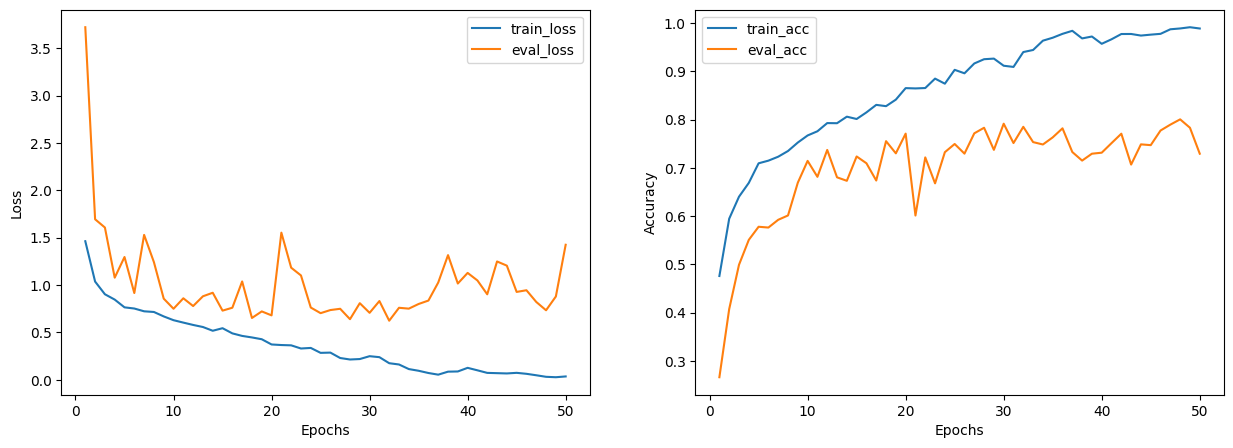

In [ ]:
plot_results(num_epochs, base_metrics)

## Transfer Learning

In [ ]:
transfer_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in transfer_model.parameters():
    param.requires_grad = False

in_features = transfer_model.fc.in_features
transfer_model.fc = nn.Linear(in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
transfer_model.to(device)

crqiterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

num_epochs = 50
model_path = './model'
os.makedirs(model_path, exist_ok=True)
model_name = 'transfer_model'

transfer_model, transfer_metrics = train(transfer_model, model_name, model_path, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| Epoch: 1 | 5/12 | Accuracy: 0.3151041666666667
| Epoch: 1 | 10/12 | Accuracy: 0.4133522727272727
-----------------------------------------------------------
| End of epoch   1 | Train Accuracy    0.430 | Train Loss    1.413 | | Valid Accuracy    0.636 | Valid Loss    1.082 
| Epoch: 2 | 5/12 | Accuracy: 0.69140625
| Epoch: 2 | 10/12 | Accuracy: 0.7283380681818182
-----------------------------------------------------------
| End of epoch   2 | Train Accuracy    0.731 | Train Loss    0.929 | | Valid Accuracy    0.790 | Valid Loss    0.750 
| Epoch: 3 | 5/12 | Accuracy: 0.796875
| Epoch: 3 | 10/12 | Accuracy: 0.8135653409090909
-----------------------------------------------------------
| End of epoch   3 | Train Accuracy    0.818 | Train Loss    0.677 | | Valid Accuracy    0.834 | Valid Loss    0.591 
| Epoch: 4 | 5/12 | Accuracy: 0.8444010416666666
| Epoch: 4 | 10/12 | Accuracy: 0.8416193181818182
-----------------------------------------------------------
| End of epoch   4 | Train A

<ipython-input-20-d76967a6df59>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path + f"/{model_name}.pt"))


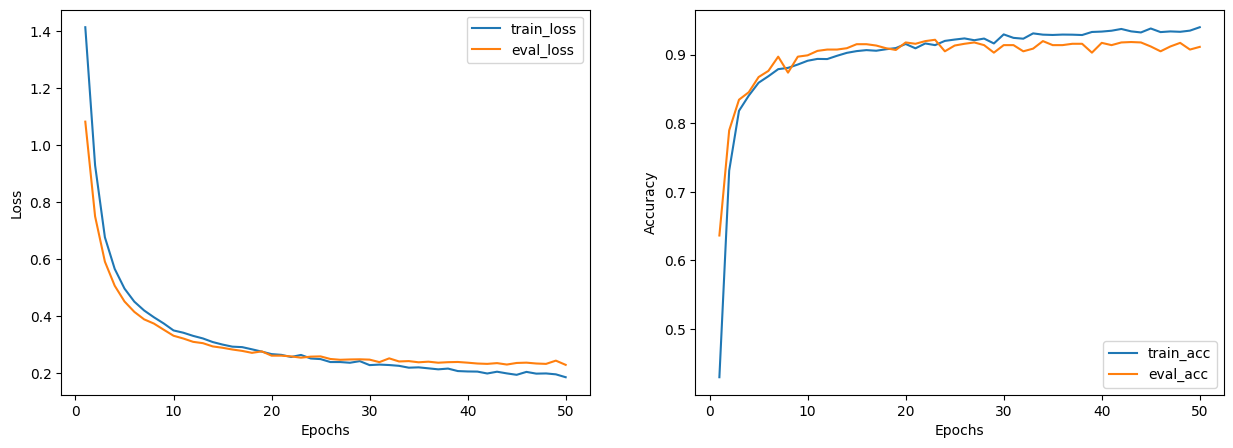

In [ ]:
plot_results(num_epochs, transfer_metrics)

## Fine tune


### Freeze layers

In [ ]:
finetune_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_layers = 50
for index, param in enumerate(finetune_model.parameters()):
    if index < num_layers:
        param.requires_grad = False

in_features = finetune_model.fc.in_features
finetune_model.fc = nn.Linear(in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
finetune_model.to(device)

crqiterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)

num_epochs = 50
model_path = './model'
os.makedirs(model_path, exist_ok=True)
model_name = 'finetune_model'

finetune_model, finetune_metrics = train(finetune_model, model_name, model_path, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| Epoch: 1 | 5/12 | Accuracy: 0.7454427083333334
| Epoch: 1 | 10/12 | Accuracy: 0.8171164772727273
-----------------------------------------------------------
| End of epoch   1 | Train Accuracy    0.825 | Train Loss    0.471 | | Valid Accuracy    0.897 | Valid Loss    0.296 
| Epoch: 2 | 5/12 | Accuracy: 0.953125
| Epoch: 2 | 10/12 | Accuracy: 0.9602272727272727
-----------------------------------------------------------
| End of epoch   2 | Train Accuracy    0.961 | Train Loss    0.116 | | Valid Accuracy    0.944 | Valid Loss    0.188 
| Epoch: 3 | 5/12 | Accuracy: 0.9856770833333334
| Epoch: 3 | 10/12 | Accuracy: 0.9865056818181818
-----------------------------------------------------------
| End of epoch   3 | Train Accuracy    0.987 | Train Loss    0.048 | | Valid Accuracy    0.945 | Valid Loss    0.130 
| Epoch: 4 | 5/12 | Accuracy: 0.998046875
| Epoch: 4 | 10/12 | Accuracy: 0.9968039772727273
-----------------------------------------------------------
| End of epoch   4 | Train 

<ipython-input-20-d76967a6df59>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path + f"/{model_name}.pt"))


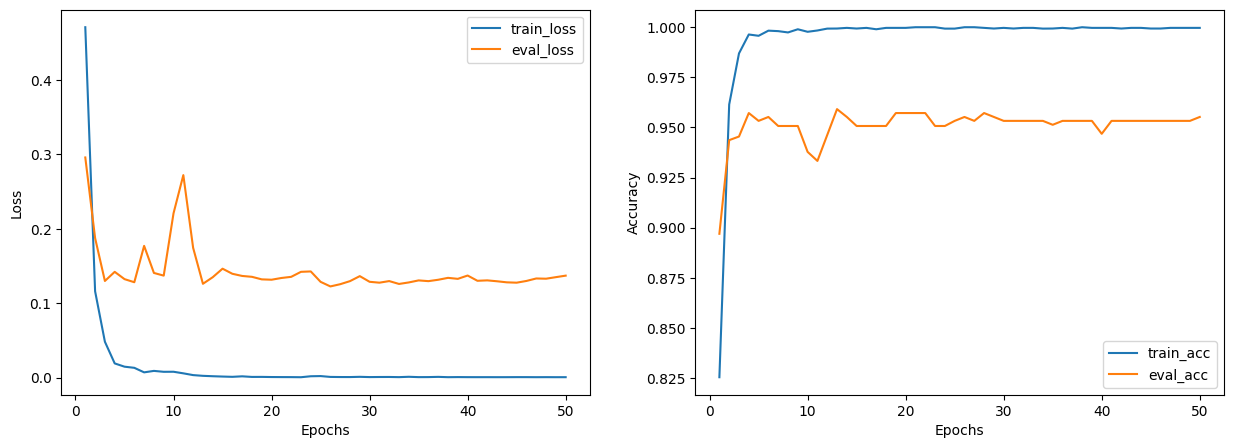

In [ ]:
plot_results(num_epochs, finetune_metrics)

### Retrain all layers

In [ ]:
init_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = init_model.fc.in_features
init_model.fc = nn.Linear(in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
init_model.to(device)

crqiterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(init_model.parameters(), lr=0.001)

num_epochs = 50
model_path = './model'
os.makedirs(model_path, exist_ok=True)
model_name = 'init_model'

init_model, init_metrics = train(init_model, model_name, model_path, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| Epoch: 1 | 5/12 | Accuracy: 0.73046875
| Epoch: 1 | 10/12 | Accuracy: 0.7908380681818182
-----------------------------------------------------------
| End of epoch   1 | Train Accuracy    0.796 | Train Loss    0.530 | | Valid Accuracy    0.614 | Valid Loss    4.162 
| Epoch: 2 | 5/12 | Accuracy: 0.9140625
| Epoch: 2 | 10/12 | Accuracy: 0.9208096590909091
-----------------------------------------------------------
| End of epoch   2 | Train Accuracy    0.922 | Train Loss    0.221 | | Valid Accuracy    0.640 | Valid Loss    2.639 
| Epoch: 3 | 5/12 | Accuracy: 0.9466145833333334
| Epoch: 3 | 10/12 | Accuracy: 0.9527698863636364
-----------------------------------------------------------
| End of epoch   3 | Train Accuracy    0.956 | Train Loss    0.129 | | Valid Accuracy    0.909 | Valid Loss    0.239 
| Epoch: 4 | 5/12 | Accuracy: 0.9798177083333334
| Epoch: 4 | 10/12 | Accuracy: 0.9772727272727273
-----------------------------------------------------------
| End of epoch   4 | Train 

<ipython-input-20-d76967a6df59>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path + f"/{model_name}.pt"))


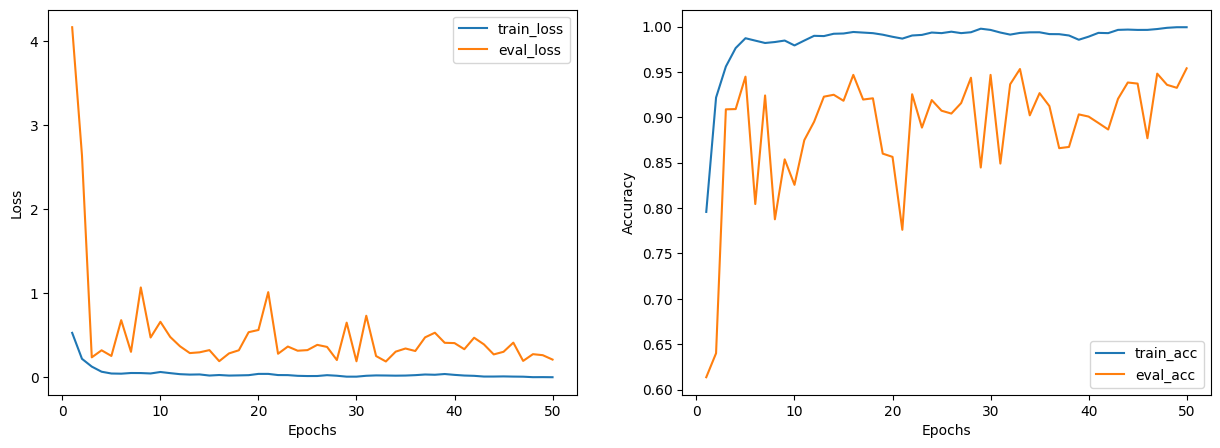

In [ ]:
plot_results(num_epochs, init_metrics)

# Image Retrieval

## Basic approach

In [ ]:
!gdown 1aZVKTLtWlrQOlLvepLasxy6qFuCl4SJm
!unzip ./images_mr.zip
!rm ./images_mr.zip

In [64]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((86, 128)),
    transforms.ToTensor()
])

def load_image(path, transform):
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img)
    return img_tensor

In [65]:
import os
len([name for name in os.listdir("./images_mr")])

9908

In [66]:
load_image(f"./images_mr/1000.jpg", transform)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
         [0.0431, 0.0510, 0.1216,  ..., 0.0902, 0.0118, 0.0118],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0314, 0.0471, 0.0196,  ..., 0.0000, 0.0000, 0.0157],
         [0.0157, 0.0118, 0.0039,  ..., 0.0078, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0157,  ..., 0.0784, 0.0000, 0.0000],
         ...,
         [0.0157, 0.0157, 0.0235,  ..., 0.0235, 0.0157, 0.0157],
         [0.0118, 0.0157, 0.0196,  ..., 0.0196, 0.0157, 0.0118],
         [0.0078, 0.0078, 0.0118,  ..., 0.0118, 0.0078, 0.0078]],

        [[0.0824, 0.0784, 0.0353,  ..., 0.0078, 0.0353, 0.0667],
         [0.0471, 0.0353, 0.0000,  ..., 0.0000, 0.0275, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0078, 0.

In [67]:
img_path = "./images_mr"
save_path = "./images_mr.pt"

lists = [i for i in range(9908)]
images = []

from tqdm import tqdm

for index in tqdm(lists):
    try:
        img_tensor = load_image(f"{img_path}/{index}.jpg", transform)
        images.append(img_tensor)
    except:
        print(f"Image not found: {img_path}/{index}.jpg")


100%|██████████| 9908/9908 [00:11<00:00, 846.55it/s] 


In [68]:
import torch
img_tensor = torch.stack(images)
img_tensor.shape

torch.Size([9908, 3, 86, 128])

In [69]:
torch.save(img_tensor, save_path)
print(f"Saved tensor to: {save_path}")

Saved tensor to: ./images_mr.pt


In [70]:
img_tensors = torch.load(save_path)
img_tensors.shape

<ipython-input-70-0f25d6d72609>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensors = torch.load(save_path)


torch.Size([9908, 3, 86, 128])

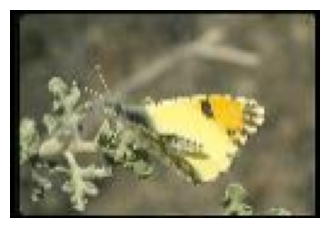

In [71]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

image_pil = to_pil_image(img_tensors[0])
plt.figure(figsize=(4, 4))
plt.imshow(image_pil)
plt.axis(False)
plt.show()

In [72]:
!wget https://www.yakult.co.jp/inbound/img/manners/05/img_01.jpg

--2025-03-07 14:17:41--  https://www.yakult.co.jp/inbound/img/manners/05/img_01.jpg
Resolving www.yakult.co.jp (www.yakult.co.jp)... 133.208.167.4
Connecting to www.yakult.co.jp (www.yakult.co.jp)|133.208.167.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134439 (131K) [image/jpeg]
Saving to: ‘img_01.jpg.1’

img_01.jpg.1        100%[===================>] 131.29K   298KB/s    in 0.4s    

2025-03-07 14:17:42 (298 KB/s) - ‘img_01.jpg.1’ saved [134439/134439]



Img tensor shape: torch.Size([3, 86, 128])


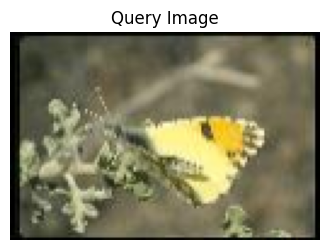

In [73]:
# Update with the correct path
query_img_path = 'images_mr/0.jpg'
query_tensor = load_image(query_img_path, transform)
print(f"Img tensor shape: {query_tensor.shape}")

# Display query image
plt.figure(figsize=(4, 4))
plt.imshow(transforms.ToPILImage()(query_tensor))
plt.title("Query Image")
plt.axis('off')
plt.show()

In [74]:
query_tensor_flat = query_tensor.view(1, -1)
print(f"Img tensor shape: {query_tensor_flat.shape}")

Img tensor shape: torch.Size([1, 33024])


In [75]:
# Load the saved tensor file containing all images
data_tensors = torch.load('images_mr.pt')
print(f"Data tensors shape: {data_tensors.shape}")
data_tensors_flat = data_tensors.view(data_tensors.size(0), -1)
print(f"Data tensors flat shape: {data_tensors_flat.shape}")

<ipython-input-75-ca6d35a76b7b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_tensors = torch.load('images_mr.pt')


Data tensors shape: torch.Size([9908, 3, 86, 128])
Data tensors flat shape: torch.Size([9908, 33024])


### L1 distance

In [76]:
distances = torch.abs(data_tensors_flat - query_tensor_flat)
distances = torch.sum(distances, dim=1)

sorted_indexes = torch.argsort(distances, descending=False)
sorted_indexes[:8]

tensor([   0, 1026, 1610, 1020, 1059, 1047, 1060, 3943])

In [77]:
for i in range(8):
    index = sorted_indexes[i].item()
    distance = distances[index].item()
    print(f"Index: {index}, Distance: {distance}")

Index: 0, Distance: 0.0
Index: 1026, Distance: 4184.01611328125
Index: 1610, Distance: 4189.11767578125
Index: 1020, Distance: 4200.80419921875
Index: 1059, Distance: 4257.859375
Index: 1047, Distance: 4287.47509765625
Index: 1060, Distance: 4317.505859375
Index: 3943, Distance: 4415.84716796875


### Cosine similarity

In [78]:
sims = torch.cosine_similarity(data_tensors_flat, query_tensor_flat)
sorted_indexes = torch.argsort(sims, descending=True)
sorted_indexes[:8]

tensor([   0, 1047, 1020, 1026, 1060, 1066, 1059, 1011])

In [79]:
for i in range(8):
    index = sorted_indexes[i].item()
    similarity = sims[index].item()
    print(f"Index: {index}, Similarity: {similarity}")

Index: 0, Similarity: 0.9999986886978149
Index: 1047, Similarity: 0.9392673373222351
Index: 1020, Similarity: 0.9308511018753052
Index: 1026, Similarity: 0.9279907941818237
Index: 1060, Similarity: 0.9266587495803833
Index: 1066, Similarity: 0.9266039729118347
Index: 1059, Similarity: 0.925909161567688
Index: 1011, Similarity: 0.9249660968780518


## Pretrained model

In [80]:
from torchvision import models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)
modules = list(resnet18.children())[:-1]
resnet18 = nn.Sequential(*modules)

resnet18.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [84]:
# Function to preprocess and extract features
def extract_features(tensor, model):
    with torch.no_grad():
        # Add batch dimension and get features
        features = model(tensor.unsqueeze(0))
        # Flatten the features
        features = features.view(features.size(0), -1)
    return features

# Extract features for each image and store them
feature_list = []
for tensor in data_tensors:
    # print(tensor.unsqueeze(0).shape)
    features = extract_features(tensor, resnet18)
    feature_list.append(features)

# Stack all features into a single tensor
feature_tensor = torch.stack(feature_list).squeeze()
print(feature_tensor.shape)
torch.save(feature_tensor, 'images_mr_features.pt')

torch.Size([9908, 512])


In [85]:
query_tensor = load_image(query_img_path, transform)
query_features = extract_features(query_tensor, resnet18)

# Load the feature tensor
feature_tensor = torch.load('images_mr_features.pt')

# Calculate cosine similarity
sims = torch.cosine_similarity(query_features, feature_tensor)

# Sort the similarities and get indices
sorted_indices = torch.argsort(sims, descending=True)

<ipython-input-85-b6629049bbf6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_tensor = torch.load('images_mr_features.pt')


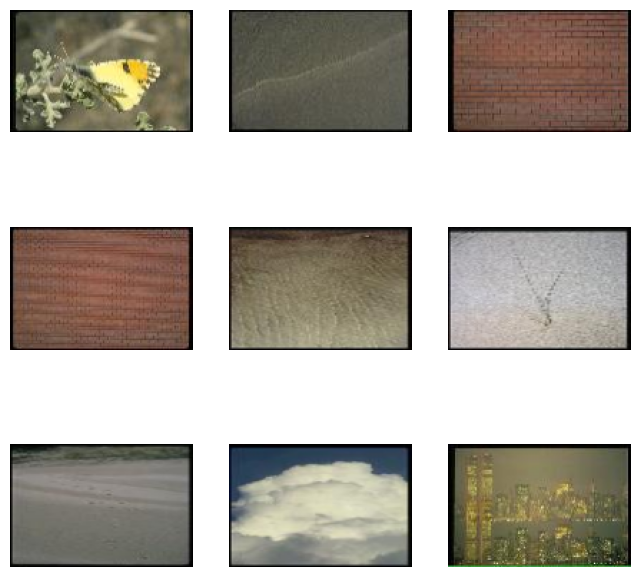

In [86]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(columns * rows):
    index = sorted_indexes[i].item()
    img = data_tensors[index]

    ax = fig.add_subplot(rows, columns, i+1)
    ax.axis("off")
    ax.imshow(to_pil_image(img))
plt.show()

# Vector Database

In [88]:
!pip install grpcio pymilvus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.70.0
    Uninstalling grpcio-1.70.0:
      Successfully uninstalled grpcio-1.70.0


In [89]:
from pymilvus import MilvusClient, connections

CLUSTER_ENDPOINT = "https://in03-9d5e58400faa441.serverless.gcp-us-west1.cloud.zilliz.com"  # get from Zilliz Cloud after create cluster
TOKEN = "1ee705ef9b10733ad2402adf92c60f21feac73b0aab0913c38bc61292fb2a21f71101deb66f18327d0385a02c3fe77512faa2311"  # get from Zilliz Cloud after create cluster

connections.connect(
    alias="default",
    uri=CLUSTER_ENDPOINT,
    token=TOKEN
)

client = MilvusClient(
    uri=CLUSTER_ENDPOINT,
    token=TOKEN
)

In [90]:
from pymilvus import Collection, DataType, FieldSchema, CollectionSchema, utility

# create a collection
COLLECTION_NAME = "ResNet18"
check_collection = utility.has_collection(COLLECTION_NAME)
if check_collection:
    drop_result = utility.drop_collection(COLLECTION_NAME)

EMBEDDING_DIM = 512

image_id = FieldSchema(
    name="image_id",
    dtype=DataType.INT64,
    is_primary=True,
    description="Image ID"
)

image_embedding = FieldSchema(
    name="image_embedding",
    dtype=DataType.FLOAT_VECTOR,
    dim=EMBEDDING_DIM
)

schema = CollectionSchema(
    fields=[image_id, image_embedding],
    auto_id=False,
    description="Image Retrieval Using ResNet18"
)

collection = Collection(
    name=COLLECTION_NAME,
    schema=schema
)

In [97]:
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision as nn
from torchvision import models, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    processed_img = transform(img)
    return processed_img

# load model
resnet18_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# remove the classification head
modules = list(resnet18_model.children())[:-1]
resnet18_model = torch.nn.Sequential(*modules)

resnet18_model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
resnet18_model.to(device)

def extract_feature(processed_image):
    input = processed_image.unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = resnet18_model(input)
    return prediction.squeeze().cpu().tolist()

In [94]:
!gdown 1aZVKTLtWlrQOlLvepLasxy6qFuCl4SJm

Downloading...
From (original): https://drive.google.com/uc?id=1aZVKTLtWlrQOlLvepLasxy6qFuCl4SJm
From (redirected): https://drive.google.com/uc?id=1aZVKTLtWlrQOlLvepLasxy6qFuCl4SJm&confirm=t&uuid=2aec6c56-c6d9-4225-80ef-932abcd2dc7c
To: /content/images_mr.zip
100% 36.5M/36.5M [00:00<00:00, 97.4MB/s]


In [98]:
image_folder = "./images_mr"

# extract feature
image_ids = sorted([
    int(image_name.split(".")[0]) for image_name in os.listdir(image_folder)
])

image_embeddings = []
for image_id in tqdm(image_ids):
    file_name = str(image_id) + ".jpg"
    image_path = os.path.join(image_folder, file_name)
    processed_image = preprocess_image(image_path)
    processed_image = extract_feature(processed_image)
    image_embeddings.append(processed_image)

# insert entities
entities = [image_ids, image_embeddings]
ins_resp = collection.insert(entities)

# flush
collection.flush()

100%|██████████| 9908/9908 [18:18<00:00,  9.02it/s]


In [99]:
# create index with L2 score
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {}
}

collection.create_index(
    field_name=image_embedding.name,
    index_params=index_params
)

# load collection
collection.load()

# search
search_params = {
    "metric_type": "L2",
    "params": {"level": 2}
}

def search_images(image_path, topk=5):
    processed_image = preprocess_image(image_path)
    processed_image = extract_feature(processed_image)
    results = collection.search(
        [processed_image],
        anns_field=image_embedding.name,
        param=search_params,
        limit=topk,
        guarantee_timestamp=1
    )
    return results[0]

In [102]:
# query image
!gdown 1aZHrliKuLOTtzM6vvLj82lwXT9Vjrsfd

Downloading...
From: https://drive.google.com/uc?id=1aZHrliKuLOTtzM6vvLj82lwXT9Vjrsfd
To: /content/q1.jpg
100% 4.04k/4.04k [00:00<00:00, 12.1MB/s]


In [103]:
image_path = "./q1.jpg"
results = search_images(image_path)
results

['image_id: 20, distance: 0.0016687080496922135, entity: {}', 'image_id: 31, distance: 167.30870056152344, entity: {}', 'image_id: 7, distance: 189.01768493652344, entity: {}', 'image_id: 1123, distance: 192.01797485351562, entity: {}', 'image_id: 57, distance: 195.010986328125, entity: {}']